# An Introduction to my Statistics Package, statfunctions

I developped a statistics package called `statfunctions` which includes many of the statistics functions that I commonly use, and a large array of linear regression, non-linear regression, and non-parametric regression classes that I commonly use.

In [1]:
import sys
sys.path.append('./code')

%matplotlib inline
import numpy as np
from statfunctions import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import erf, erfinv
sns.set_style('white')
sns.set_context('notebook')
import re

Here is a very simple case where I am doing an array of linear regression fits using the `PolynomialFit1D` objects. These are all specified to be quadratic fits, and then the list of regression objects can be plotted together with the `regression_plot` method.

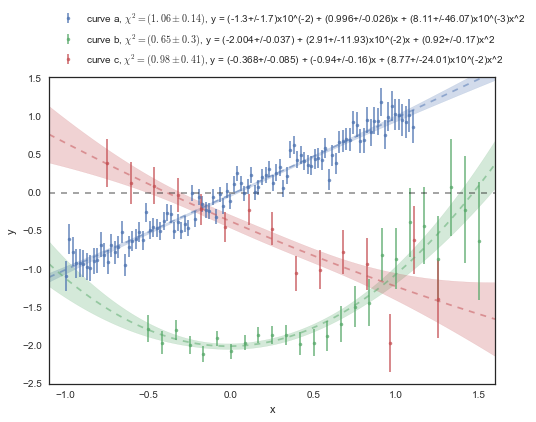

In [2]:
x  = [np.linspace(-1,1.1,100), 
      np.linspace(-.5,1.5,25), 
      np.linspace(-.75, 1.25, 15)]

dy = [(1 + x[0]**2) * np.ones(x[0].shape)/10, 
      (1 + 3*x[1]**2)*np.ones(x[1].shape)/10, 
      (1 + x[2]**2) * np.ones(x[2].shape)/5]

labels = ['curve a', 'curve b', 'curve c']

y = [dy[0] * np.random.normal(size = x[0].shape) + x[0],
     dy[1] * np.random.normal(size = x[1].shape) + x[1]**2 - 2,
     dy[2] * np.random.normal(size = x[2].shape) + x[2]**3/3 -.5 - x[2]]


regrs = [PolynomialFit1D(x[i], y[i], dy[i], order=2, label=labels[i]) for i in range(len(y))]

regression_plot(regrs, legend=True, fit_expression=True, max_label_length=115)

Here are the same plots, but in different windows using the class method `regr.plot()`.

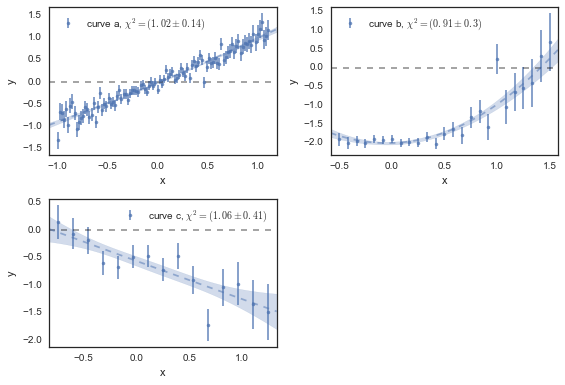

In [10]:
plt.figure()
for i in range(len(regrs)):
    plt.subplot(2,2,i+1)
    regrs[i].plot(fit_expression=False)
plt.tight_layout()

Fit coefficients can be obtained in a dataframe as follows:

In [9]:
regrs[0].get_coefficients()

,names,units,value,dvalue,significance,p(zero)
0,a(0),,-0.014757,0.016830,0.876845,0.762330
1,a(1),,0.948449,0.026119,36.311966,0.000000
2,a(2),,0.057794,0.046072,1.254426,0.506375


plot residuals, and a histogram of those residuals are readily accessible:

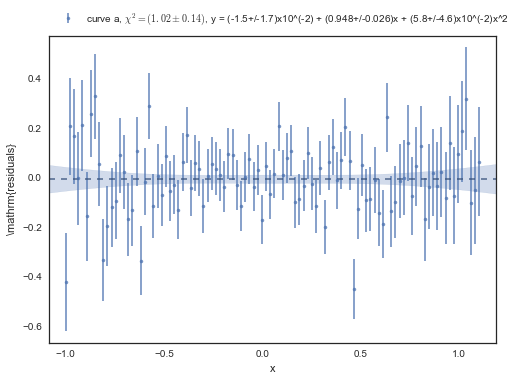

In [18]:
regrs[0].plot(residuals=True)

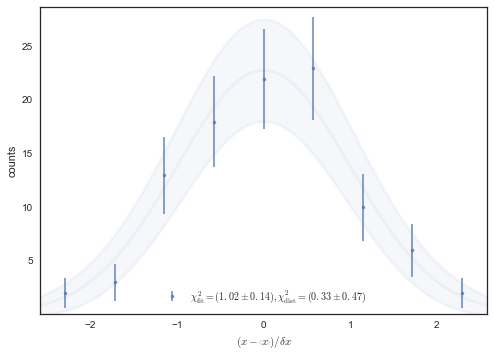

In [19]:
regrs[0].histogram()

So far, we have only considered the pretty limited `PolynomialFit1D` linear regression class. 1D linear regression with generic models can be performed on the fly with `LinearRegression1D`.

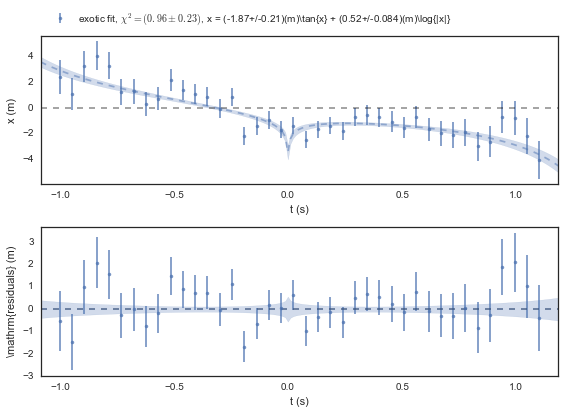

In [22]:
N =40

x = np.linspace(-1,1.1,N)
dy = (1 + x**2) * np.ones(x.shape)/1.5
y = dy*np.random.normal(size=(N,)) - 2 * np.tan(x) + .5 * np.log(np.abs(x))
model = lambda x: np.array([np.tan(x), np.log(np.abs(x))])

regr_gen  =  LinearRegression1D(x, y, dy, model_function=model, 
                                                label='exotic fit',
                                                x_name='t',
                                                y_name='x',
                                                x_unit='s',
                                                y_unit='m',
                                                basis_names=['\\tan{x}', '\\log{|x|}'],
                                                coefficient_units=['m', 'm'])

plt.figure()
plt.subplot(2,1,1)
regr_gen.plot()
plt.subplot(2,1,2)
regr_gen.plot(residuals=True, legend=False, fit_expression=False)
plt.tight_layout()

Here is another built-in 1D linear regression class, `SineFit1D` that can fit linear combinations of sines of different frequencies and phases.

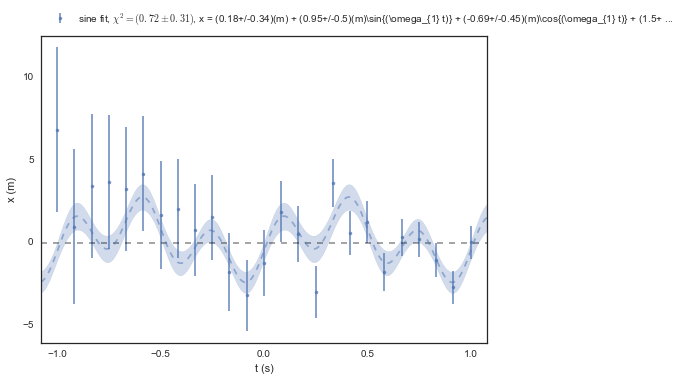

In [24]:
N = 25

x = np.linspace(-1,1,N)
dy = (1 + (x - 1)**2)* np.ones(x.shape)
y = (dy * np.random.normal(size=(N,)) + .5 +
     np.sin(2 * np.pi * x) - np.cos(2 * np.pi * x) 
     + np.sin(2 * np.pi * 3 * x))


regr_sine = SineFit1D(x, y, dy, frequencies=[1, 3],
                            phases=[None, 0],
                            offset=True,
                            label='sine fit',
                            x_name='t',
                            y_name='x',
                            x_unit='s',
                            y_unit='m')

regr_sine.plot()

Again, all of these different linear regression classes are compatible with the grouped plot method `regression_plot`.

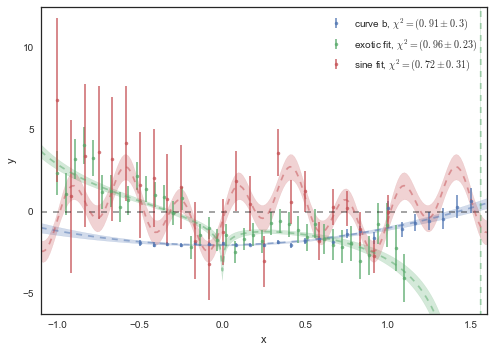

In [27]:
regression_plot([regrs[1], regr_gen, regr_sine], legend=True)

# Removing Outliers
I have added a method to the regression classes that enables removal of outliers.

Here is a some data that follows the functional behavior of a line. The data is mostly normally distributed, but a small fraction of the data is lorentzian distributed that results in large outlier values. Here is a plot of the fit before and after rejecting outliers with $p=.05$.

C:\Anaconda\envs\py35\lib\site-packages\ipykernel\__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


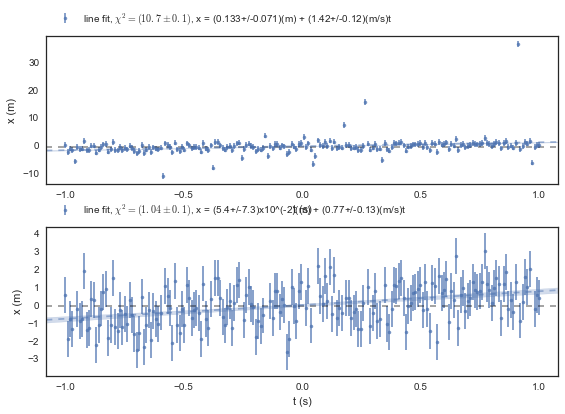

In [33]:
N = 200

x = np.linspace(-1,1,N)
noise = np.append(np.random.standard_cauchy(size=(N/4,)), np.random.normal(size=(3*N/4,)))
noise = noise.flatten()
noise = noise[np.random.permutation(N)]
y = noise + x
dy = np.ones(N)

regr = PolynomialFit1D(x, y, dy=dy, order=1, 
                                            label='line fit',
                                            x_name='t',
                                            y_name='x',
                                            x_unit='s',
                                            y_unit='m')
plt.subplot(2,1,1)
regr.plot()
plt.subplot(2,1,2)
regr.remove_outliers()
regr.plot(p=.05)
plt.tight_layout()

# Linear Regression with Linear Constraints

I included the capability to include linear constraints on the linear coefficients. If the linear coefficients are $a_i$, a linear constraint of the form:
$\sum{a_i c_i}_i = b$
is specified by a tuple with two elements, where the first entry is a list of the linear coefficients for the constraint and the second element is the offset,

`([c_0, ... , c_N], b)`

Here is a comparison of a fit with and without the linear constraints.

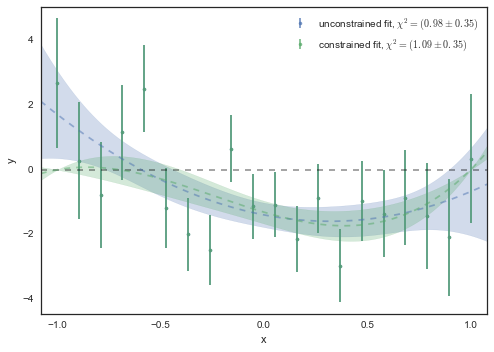

In [37]:
N = 20
x = np.linspace(-1, 1, N)
dy = (1 + x**2) * np.ones(N)
y = dy * np.random.normal(size=(N,)) + (x - 1) * (x + 1)**2

order = 3

constraints = [([1 for i in range(order + 1)], 0),
               ([(-1)**i for i in range(order + 1)], 0)]

regr_unconstrained = PolynomialFit1D(x, y, dy, 
                                     order=order, 
                                     label='unconstrained fit')
regr_constrained   = PolynomialFit1D(x, y, dy, 
                                     order=order, 
                                     label='constrained fit', 
                                     constraints=constraints)

regression_plot([regr_unconstrained, 
                 regr_constrained], 
                 legend=True)

# Verifying the Statistical Validity of the Reported Confidence Intervals

My regression objects provide confidence intervals on the linear fit coefficients. Here, we can show that the uncertainties provided on these coefficients obtained from the constrained fit are valid using a monte carlo simulation.

C:\Anaconda\envs\py35\lib\site-packages\scipy\optimize\minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


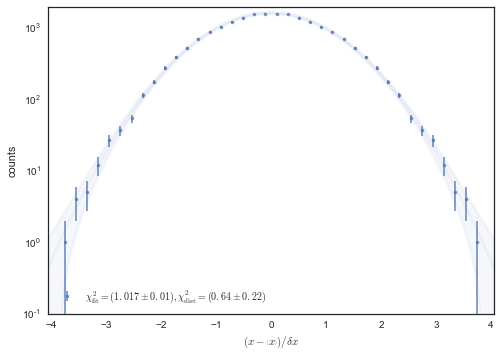

In [39]:
reps = 5000

coeffs  = []
dcoeffs = []

for i in range(reps):

    N = 250
    x = np.linspace(-1, 1, N)
    dy = (1 + x**2) * np.ones(N)
    y = dy * np.random.normal(size=(N,)) + 1 - 1. * x - 1. * x**2 + 2 * x**3

    order = 3

    constraints = [([1 for i in range(order + 1)], 1),
                   ([int(i < 2) for i in range(order + 1)], 0)]

    regr_constrained   = PolynomialFit1D(x, y, dy, 
                                         order=order, 
                                         label='constrained fit', 
                                         constraints=constraints)
    
    coeffs.append(regr_constrained.coefficients)
    dcoeffs.append(regr_constrained.dcoefficients)
    
coeffs = np.array(coeffs)
dcoeffs = np.array(dcoeffs)

t_hist(coeffs, dcoeffs, axis=0, yscale='log')

# Fourier Transform as Linear Regression

Here is a fourier transform linear regression method that can perform the fourier transform on real functions. This is similar to the `np.fft.rfft` in the numpy package. This function, however, propogates errors through the fourier transform, enables variation in uncertainty in each data point, and can handle abnormalities in the data such as jitter in the time dimension (deviation from a uniform sampling rate), or missing data points within a uniform sampling dataset.

The fourier transform linear regression can serve as a method for obtaining a non-parametric fit function as well. A model can be built of the basis functions that correspond to the non-zero fourier components. The cut-off for inclusion can be determined either by a p-value cutoff, or by using a cross-validation method.

First, here is an example of the fourier transform of a sum of two cosine functions at different frequency with noise. The fourier transform can be thought of as a fit function with the number of degrees of freedom equal to that of the dataset resulting in a fit function that matches the mean  value and uncertainties of every datapoint. I am showing a comparison here between the results from the Linear Regression Fourier Transform (LRFT) and the Real Fast Fourier Transform (RFFT). It is notable that the RFFT is much much faster than the LRFT, but the RFFT does not provide error estimates. The LRFT should be used instead of  the RFFT in the case of small datasets, or in the case that extraction of meaningful uncertainties is critical.

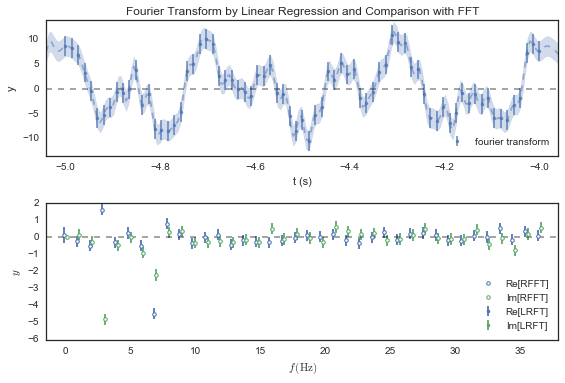

In [47]:
N = 75
x = np.linspace(0, 1, N) - 5
dy = np.ones(N) * 2
y = dy * np.random.normal(size=(N,)) + (5 * np.cos(2 * np.pi * 3 * x) + 
                                        5 * np.cos(2 * np.pi * 7 * x)     )


regr = FourierTransform(x, y, dy, 
                        x_name='t', x_unit='s', f_unit='Hz',
                        label='fourier transform')

plt.figure()
plt.subplot(2,1,1)
regr.plot(fit_expression=False, chi2=False)
plt.title('Fourier Transform by Linear Regression and Comparison with FFT')
plt.subplot(2,1,2)
regr.plot_fourier_transform(show_fft=True)
_=plt.legend(loc='best')
plt.tight_layout()

Here is a second example of use of the LRFT. In this case, jitter is added on the sampling time. This is one example of a problem that the usual FFT has difficulty with, but the LRFT solves trivially. Here, we also have the option of creating a 'reduced dimension model' - this returns a regression object with a model that removed all of the terms which had coefficients that were sufficiently consistent with zero. 

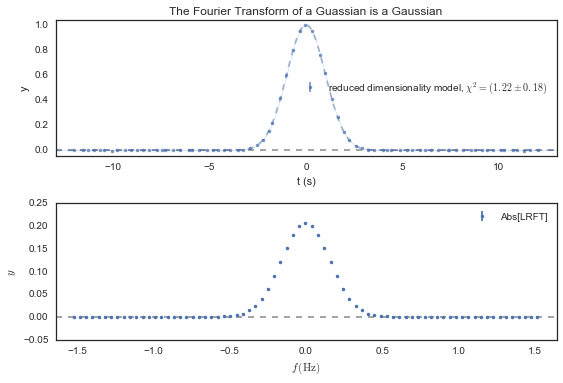

In [49]:
N =75
x_range = 12
x = np.linspace(-x_range, x_range, N) + np.random.normal(size=(N,)) * (2 * x_range) / (float(N)) * .2
dy = np.ones(N) / 1000.0
y = dy * np.random.normal(size=(N,)) + np.exp(-x**2/2.0)

label = 'Fourier Transform of a Modulated Gaussian'

regr = FourierTransform(x, y, dy, label=label, x_name='t', x_unit='s', f_unit='Hz')
regr2 = regr.get_reduced_dimension_model(p=.5, label='reduced dimensionality model')

plt.subplot(2,1,1)
regr2.plot(fit_expression=False)
plt.title('The Fourier Transform of a Guassian is a Gaussian')
plt.subplot(2,1,2)
regr.plot_fourier_transform(show_negative=True, amplitude=True)
plt.legend(loc='best')
plt.tight_layout()

Here is another problem that the usual FFT has difficulty with - dealing with missing data. Again, the LRFT solves that problem trivially.

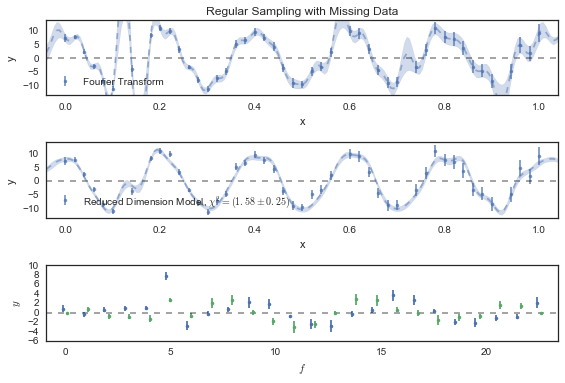

In [51]:
N = 51
n_remove = 5

remove_inds = np.random.permutation(N)[:n_remove]
delete_inds = lambda a: np.delete(a, remove_inds)

x = np.linspace(0, 1, N)
dy = (1 + x**2 * 2 + .15 * np.random.normal(size=(N,))) * np.ones(N)
y = dy * np.random.normal(size=(N,)) + 10 * np.cos(2 * np.pi * 5 * x)

x = delete_inds(x)
y = delete_inds(y)
dy= delete_inds(dy)

regr = FourierTransform(x, y, dy, label='Fourier Transform')
regr2= regr.get_reduced_dimension_model(p=.75, label='Reduced Dimension Model')

plt.subplot(3,1,1)
regr.plot(chi2=False, fit_expression=False)
plt.legend(loc=3)
plt.title('Regular Sampling with Missing Data')
plt.subplot(3,1,2)
regr2.plot(fit_expression=False)
plt.legend(loc=3)
plt.subplot(3,1,3)
regr.plot_fourier_transform()
plt.tight_layout()

You can also perform a transformation to examine the results in amplitude and phase space. Here is an example where phase noise is added on the data points, and the resulting fourier transform shows a well behaved amplitude and a poorly behaving phase.

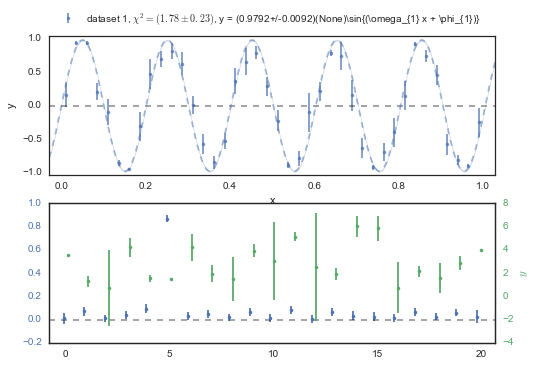

In [53]:
N = 200
x = np.linspace(0, 1, N)
y = np.sin(2*np.pi*5*x + (np.pi/8) * np.random.normal(size=(N,)))
binning = lambda array, bin_size: unweighted_mean(np.reshape(array,(len(array)//bin_size, bin_size)), axis=1)
n = 5
X, dX = binning(x, n)
Y, dY = binning(y, n)

regr = FourierTransform(X, Y, dY)
regr2 = regr.get_reduced_dimension_model()
plt.subplot(2,1,1)
regr2.plot()
plt.subplot(2,1,2)
regr.plot_fourier_transform(amplitude=True, phase=True)

# 2D Linear Regression

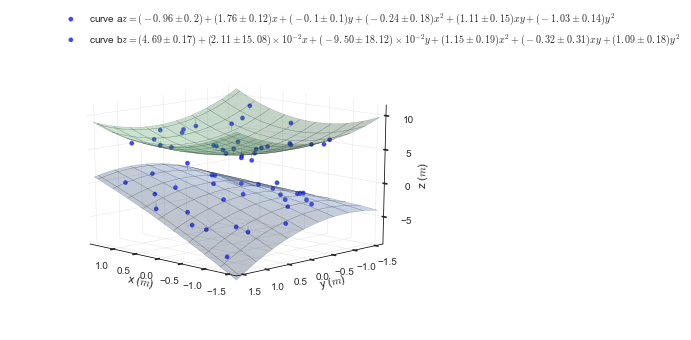

In [4]:
N = 30

x = [(np.random.rand(N) -.5) * 3, (np.random.rand(N) -.5) * 3]
y = [(np.random.rand(N) -.5) * 3, (np.random.rand(N) -.5) * 3]

dz = [np.ones(N) /2 , (1 + x[1]**2 * y[1]**2) * np.ones(N) / 2]
z = [dz[0] * np.random.normal(size=(N,)) - 1 + 2*x[0] - y[0]**2 + x[0] * y[0],
     dz[1] * np.random.normal(size=(N,)) + x[1]**2 + y[1]**2 + 5]

labels = ['curve a', 'curve b']
x_names = ['x', 'y']
y_name  = 'z'
x_units = ['m', 'm']
y_unit  = 'm'

basis_names = ['', 'x', 'y', 'x^2', 'xy', 'y^2']

model_function = lambda x: np.array([np.ones(len(x[0])),
                                     x[0],
                                     x[1],
                                     x[0]**2,
                                     x[0] * x[1],
                                     x[1]**2])

regrs = [LinearRegression2D([x[i], y[i]], z[i], dz[i], 
                             model_function=model_function,
                             x_names=x_names, y_name=y_name,
                             x_units=x_units, y_unit=y_unit,
                             label=labels[i], 
                             basis_names=basis_names) for i in range(len(z))]

_ = plot3D(regrs, v_angle=15, h_angle=135, 
           legend=True, fit_expression=True, chi2=False)

Here is another example, with multiple colors accorded by having a single curve in the plot:

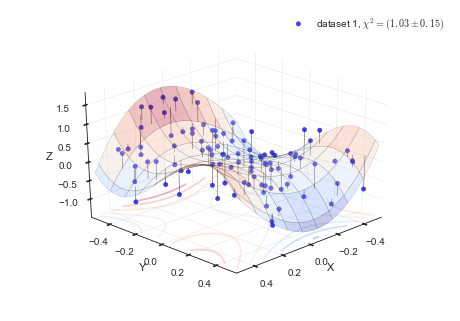

In [4]:
N = 100
x = np.random.rand(N) - .5
y = np.random.rand(N) - .5
dz = (1 + x**2 + y**2) * np.ones(N) /3
z = dz * np.random.normal(size=(N,)) + x /2 - 6 * y**3 + x**2 * y * 10

regr = PolynomialFit2D([x, y], z, dz, order=3)

_=regr.plot(legend=True)

And here are the residuals:

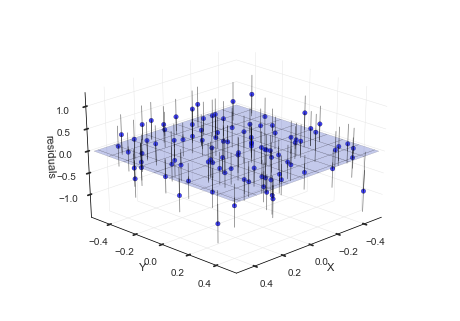

In [7]:
_=regr.plot(residuals=True, errorbars=True)

# Non-Linear Fitting

I have also built regression objects that are similar to the linear regression objects that are a wrapper for `scipy.optimize.curve_fit`. Here are two gaussian fits - one uses the generic `NonLinearFit1D` object, and feeds it the model function with a sympy symbolic expression. The other one uses `GuassianFit1D` which already has the gaussian model built in.

In [8]:
from sympy import symbols, exp

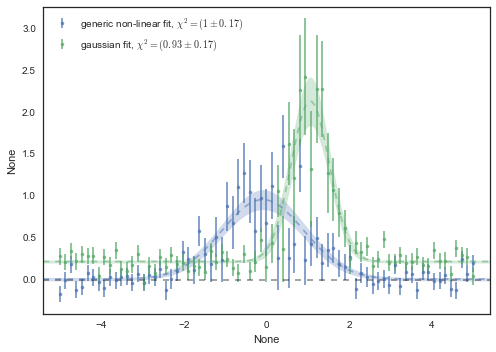

In [11]:
# create model function
x, a, x0, s, c = symbols('x a x0 s c')
variables  = (x, a, x0, s, c)
expression = a * exp(-(x - x0)**2 / (2 * s**2)) + c

# create artificial data
N  = 75
X  = np.linspace(-5,5,N)
Y  = [np.exp(-X**2/2.0), (2.0) * np.exp(-(X - 1)**2/.5)]
X  = [X] * 2
dY = [.3 * Y[i] + .1 for i in range(len(Y))] 
Y  = [Y[i] + dY[i] * np.random.normal(size=(N,)) + .2 * i for i in range(len(X))]

# perform linear regression via two methods
regrs = [NonLinearFit1D(X[0],Y[0],dY[0], 
                        variables=variables, expression=expression,
                        label='generic non-linear fit'),
         GaussianFit1D(X[1], Y[1], dY[1], offset=True, start_point=[1, 1, 1, 1],
                        label='gaussian fit')]

regression_plot(regrs, legend=True)

# Non-Parametric Kernel Regression Methods

Here is an example use case of non-parametric kernel regression methods. Here, you can use a variety of kernels from square, to gaussian, to polynomial, and a variety of estimation methods, such as boxcar averaging and local linear regression with a fixed width.

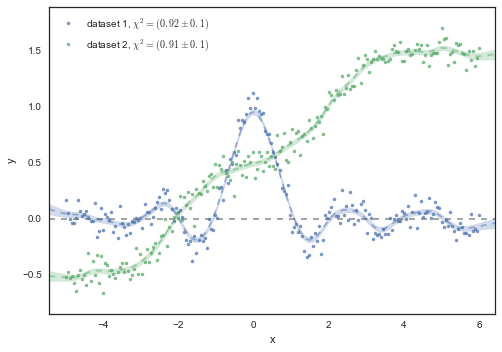

In [3]:
N = 200
x = np.linspace(-5, 6, N)
dy = np.ones(N)/12.0
y_i = np.sinc(x)
y_0 = dy * np.random.normal(size=(N,)) + y_i

y_i = (np.tanh(x-2) + np.tanh(x+2) + 1) / 2.0
y_1 = dy * np.random.normal(size=(N,)) + y_i

regr0 = KernelEstimator1D(x, y_0, dy=dy)#, method='quadratic', width=.35)

regr1 = KernelEstimator1D(x, y_1, dy=dy)

regression_plot([regr0, regr1], errorbars=False, alpha_data=.75, legend=True)

# Cross Validation

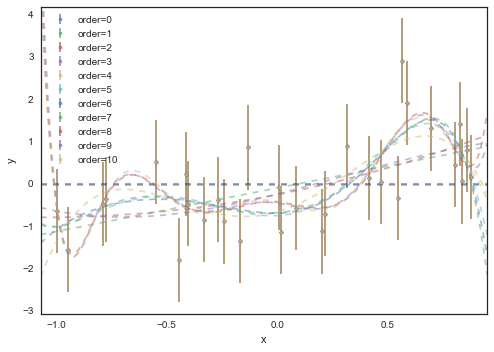

In [41]:
N = 30
x = np.random.rand(N) * 2 - 1
dy = np.ones(N)
y = dy * np.random.normal(size=(N,)) + x
order = 10

regrs = [PolynomialFit1D(x, y, dy, order=i, label=('order=' + str(i))) for i in range(0,order + 1)]
regression_plot(regrs, legend=True, fit_errors=False, chi2=False)

# Leverage and Cooks Distance

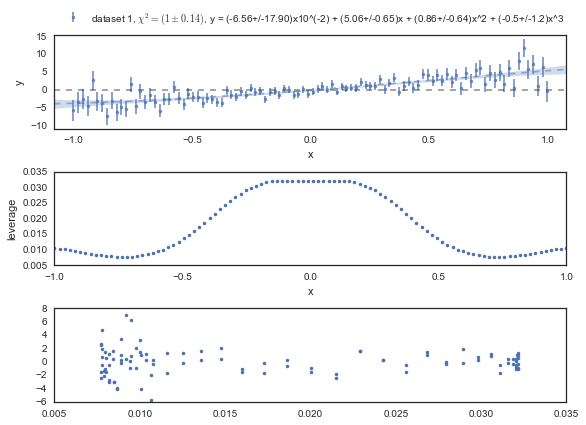

In [44]:
#X = self.evaluate_x_functions(self.data.x)
#Xdy = X/np.expand_dims(self.data.dy, 0)
#hat = np.dot(np.dot(X.T, self.covariance), Xdy)

x  = np.linspace(-1, 1, 100)
dy = np.ones(len(x))*(1 + 2 * x**2)
y  = np.random.normal(size=(len(x),)) * dy + 5 * x
self = PolynomialFit1D(x, y, dy, order=3)

X = self.evaluate_x_functions(self.data.x)/self.data.dy**2
leverage = np.diag(np.dot(np.dot(X.T, self.covariance), X))
residuals = self.residuals()
#plt.plot(leverage, residuals,'.')
#plt.errorbar(leverage, residuals, self.data.dy, fmt='.')
plt.subplot(3,1,1)
self.plot(legend=True)
plt.tight_layout()
plt.subplot(3,1,2)
plt.plot(self.data.x.T, leverage, '.')
plt.xlabel('x')
plt.ylabel('leverage')
plt.subplot(3,1,3)
plt.plot(leverage, residuals,'.')